# Classifying Planets

## Introduction

In this classification problem, we embark on a journey where we are presented with a synthetic dataset of planets and moons of our solar system. Our mission is clear: **classify from an image the planet or moon**.

In [73]:
import os
import random
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

In [74]:
# Set the random seed for reproducibility
seed = 77

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

## Load the data

In [75]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "data/raw/.",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128)
)

Found 13901 files belonging to 6 classes.


## Exploring the data

In [76]:
print('Data shape:', dataset.element_spec[0].shape)
print('Data type:', dataset.element_spec[0].dtype)
print('Label shape:', dataset.element_spec[1].shape)
print('Label type:', dataset.element_spec[1].dtype)

labels = dataset.class_names

# Print the labels
print("Labels:")
for i, label in enumerate(labels):
    print(f"{i:4}: {label}")


Data shape: (None, 128, 128, 3)
Data type: <dtype: 'float32'>
Label shape: (None,)
Label type: <dtype: 'int32'>
Labels:
   0: cardboard
   1: glass
   2: metal
   3: paper
   4: plastic
   5: trash


2025-11-14 12:34:01.894438: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


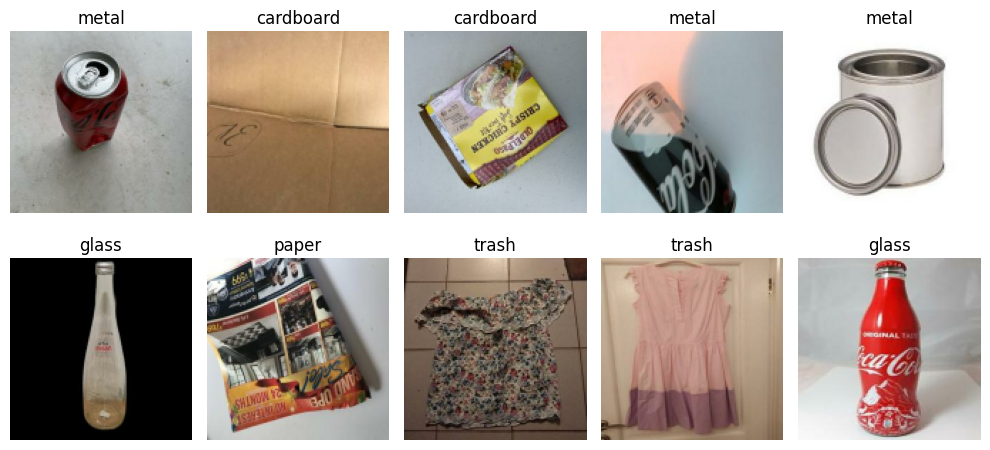

In [77]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

## Preparing the data

The following steps are performed to prepare the data:

- Shuffling the data
- Splitting the data into training and validation sets
- Normalizing the data

In [78]:
ds_train, ds_test = tf.keras.utils.image_dataset_from_directory(
    "data/raw/.",
    labels="inferred",
    label_mode="int",
    color_mode="grayscale", #grayscale
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
)

Found 13901 files belonging to 6 classes.
Using 11121 files for training.
Using 2780 files for validation.


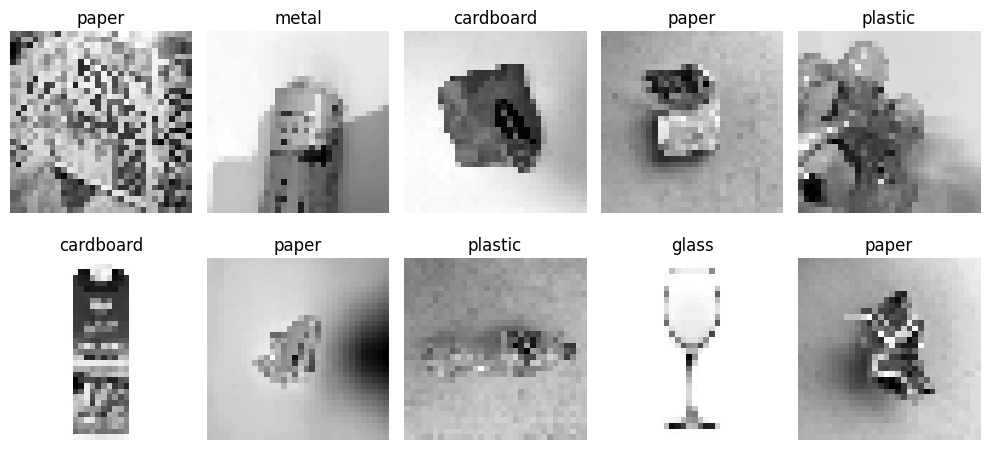

In [79]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_train.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy(), cmap="gray")
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

In [80]:
# Normalize the data
normalization_layer = tf.keras.layers.Rescaling(
    1.0 / 255
)
ds_train = ds_train.map(lambda x, y: (normalization_layer(x), y))
ds_test = ds_test.map(lambda x, y: (normalization_layer(x), y))


## Training the model

In [123]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            16, (3, 3), activation="mish", input_shape=(32, 32, 1), padding="same"
        ),
        tf.keras.layers.Conv2D(16, (3, 3), activation="mish", padding="same"),
        tf.keras.layers.MaxPooling2D((3, 3)),

        # Block 2
        tf.keras.layers.Conv2D(16, (3, 3), activation="mish", padding="same"),
        tf.keras.layers.Conv2D(16, (3, 3), activation="mish", padding="same"),
        tf.keras.layers.MaxPooling2D((3, 3)),

        # Block 3
        tf.keras.layers.Conv2D(64, (3, 3), activation="mish", padding="same"),

        tf.keras.layers.Flatten(),
        #tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(64, activation="mish"),
        tf.keras.layers.Dense(6),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)              │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 10, 10, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 10, 10, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 3, 3, 64)       │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,718 (209.84 KB)

 Trainable params: 53,718 (209.84 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 1.6697 - sparse_categorical_accuracy: 0.2950 - val_loss: 1.5225 - val_sparse_categorical_accuracy: 0.4058
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 1.4619 - sparse_categorical_accuracy: 0.4251 - val_loss: 1.4227 - val_sparse_categorical_accuracy: 0.4514
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 1.3314 - sparse_categorical_accuracy: 0.4862 - val_loss: 1.2925 - val_sparse_categorical_accuracy: 0.4968
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 1.2368 - sparse_categorical_accuracy: 0.5262 - val_loss: 1.2353 - val_sparse_categorical_accuracy: 0.5259
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 1.1717 - sparse_categorical_accuracy: 0.5515 - val_loss: 1.2285 - val_sparse_categorical_accuracy: 0.5335
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 1.0979 - sparse_categorical_accuracy: 0.5886 - val_loss: 1.1647 - val_sparse_categorical_accuracy:

## Model Evaluation

Evaluate the model on the validation set.

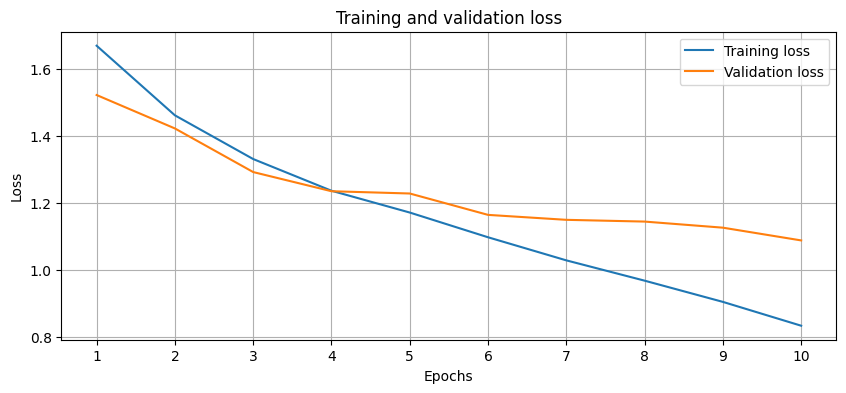

In [125]:
# Plot the training and validation loss
history = model.history.history
epochs = range(1, len(history["loss"]) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, history["loss"], label="Training loss")
plt.plot(epochs, history["val_loss"], label="Validation loss")
plt.xticks(epochs)
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [126]:
# Print validation metrics
val_loss, val_acc = model.evaluate(ds_test)
print(f"Validation loss: {val_loss:.2f}")
print(f"Validation accuracy: {val_acc * 100:.2f}%")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0885 - sparse_categorical_accuracy: 0.6151
Validation loss: 1.09
Validation accuracy: 61.51%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


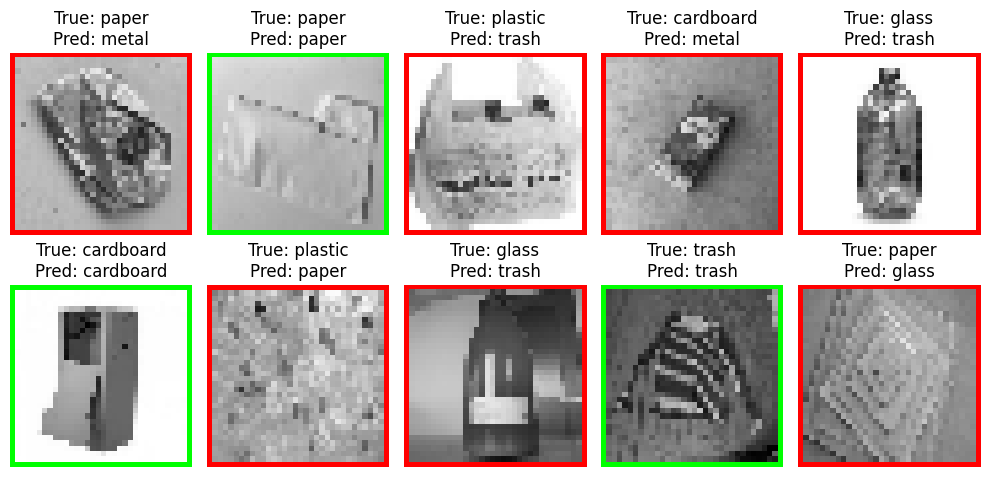

In [127]:
# Take 10 random images from the test set and show the model's predictions
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_test.take(1):
    preds = model.predict(images)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img = (images[i].numpy() * 255).astype("uint8")
        # Convert image to rgb if grayscale
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            img = np.stack((img,) * 3, axis=-1)
        true_label = labels[label_idxs[i].numpy()]
        pred_label = labels[np.argmax(preds[i])]
        # Add red border if the prediction is wrong else add green border
        img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)))
        if true_label != pred_label:
            img[0, :, 0] = 255  # Top border
            img[-1, :, 0] = 255  # Bottom border
            img[:, 0, 0] = 255  # Left border
            img[:, -1, 0] = 255  # Right border
        else:
            img[0, :, 1] = 255
            img[-1, :, 1] = 255
            img[:, 0, 1] = 255
            img[:, -1, 1] = 255

        plt.imshow(img)
        plt.title(f"True: {true_label}\n" f"Pred: {pred_label}")
        plt.axis("off")
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


2025-11-14 13:00:46.320931: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


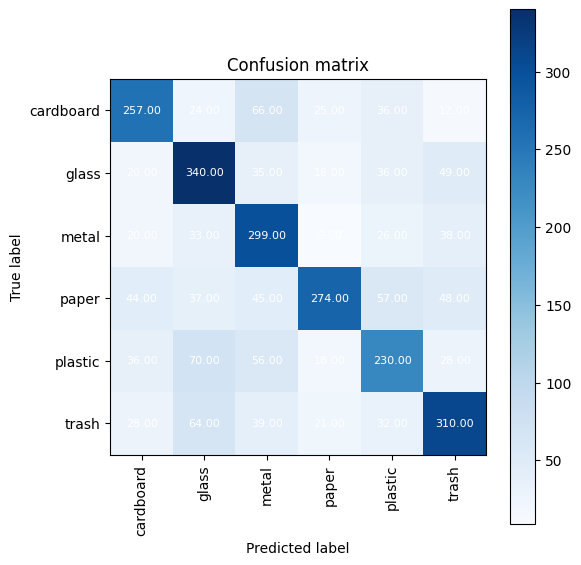

In [128]:
# Show confusion matrix of confidence per class for the test set
plt.figure(figsize=(6, 6), tight_layout=True)
preds = model.predict(ds_test)

conf_matrix = tf.math.confusion_matrix(
    labels=tf.concat([y for _, y in ds_test], axis=0),
    predictions=tf.argmax(preds, axis=1),
    num_classes=len(labels),
)

# Plot the confusion matrix
plt.imshow(conf_matrix, cmap="Blues")

# Plot cell values
for i in range(len(labels)):
    for j in range(len(labels)):
        value = conf_matrix[i, j].numpy()
        if value == 0:
            color = "lightgray"
        elif value > 0.5:
            color = "white"
        else:
            color = "black"
        plt.text(
            j,
            i,
            f"{value:.2f}",
            ha="center",
            va="center",
            color=color,
            fontsize=8,
        )

plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show()

In [129]:
# Score accuracy, precision and f1-score of model on the test set
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {test_acc * 100:.2f}%")
from sklearn.metrics import precision_score, f1_score
y_true = tf.concat([y for _, y in ds_test], axis=0).numpy()
y_pred = tf.argmax(preds, axis=1).numpy()

# Report scikit-learn classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=labels)
print("Classification Report:")
print(report)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0885 - sparse_categorical_accuracy: 0.6151
Test loss: 1.09
Test accuracy: 61.51%
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.63      0.61      0.62       420
       glass       0.60      0.68      0.64       498
       metal       0.55      0.70      0.62       425
       paper       0.75      0.54      0.63       505
     plastic       0.55      0.53      0.54       438
       trash       0.64      0.63      0.63       494

    accuracy                           0.62      2780
   macro avg       0.62      0.62      0.61      2780
weighted avg       0.62      0.62      0.61      2780

